In [1]:
%ls ../data | grep "no-border"

labels.PA66GF30-no-border.raw
PA66GF30-no-border.raw
PA66GF30-no-border.raw.info


In [2]:
!cat ../data/PA66GF30-no-border.raw.info

! PyHST_SLAVE VOLUME INFO FILE
NUM_X = 1300
NUM_Y = 1040
NUM_Z = 1900


In [24]:
import functools
import pathlib
import pickle

import numpy as np
import pymicro
from pymicro.file import file_utils
import IPython
from IPython.display import clear_output
import matplotlib
from matplotlib import pyplot as plt, cm

In [4]:
from platform import python_version
print(python_version())

3.8.2


In [6]:
print("Version of the third-party packages here:")
for pack in [pymicro, np, IPython, matplotlib]:
    print(f"\t{pack.__name__}=={pack.__version__}")

Version of the third-party packages here:
	pymicro==0.4.5
	numpy==1.19.1
	IPython==7.18.1
	matplotlib==3.3.1


In [32]:
here = pathlib.Path(".").resolve()
data_dir = (here / "../data").resolve()
data_filepath = (data_dir / "PA66GF30-no-border.raw").resolve()
labels_filepath = (data_dir / "labels.PA66GF30-no-border.raw").resolve()

In [8]:
# this is just a trick to give names to these values
# and put them together
class label:
    matrix = 0
    fiber = 1
    porosity = 2

labels_list = [0, 1, 2]

dimensions = (1300, 1040, 1900)
dtype = "uint8"

# prefill the function `HST_read`
hst_read = functools.partial(
    file_utils.HST_read,
    autoparse_filename=False,  # the file names are not properly formatted
    data_type=dtype,
    dims=dimensions,
    verbose=True,
)

In [9]:
data = hst_read(data_filepath)
labels = hst_read(labels_filepath)

data type is uint8
volume size is 1300 x 1040 x 1900
reading volume... from byte 0
data type is uint8
volume size is 1300 x 1040 x 1900
reading volume... from byte 0


In [10]:
type(data), data.shape, data.dtype

(numpy.ndarray, (1300, 1040, 1900), dtype('uint8'))

In [11]:
type(labels), labels.shape, labels.dtype

(numpy.ndarray, (1300, 1040, 1900), dtype('uint8'))

In [12]:
assert data.shape == labels.shape

In [13]:
random_state = np.random.RandomState(42)

# Find XY slices

In [14]:
crop_size = 128  # 128 x 128 pixels square
n_crops = 1000

volume_shape = data.shape
axes_limits = (
    # x and y are smaller because i will get a random
    # coordinate of the left most and upper most pixel of the crop
    (0, volume_shape[0] - crop_size),  # x-axis
    (0, volume_shape[1] - crop_size),  # y-axis
    (0, volume_shape[2]),  # z-axis
)

## No porosity

In [15]:
def does_not_have_porosity(label_crop_: np.ndarray) -> bool:
    return np.all(label_crop_ != label.porosity)

In [16]:
condition = does_not_have_porosity

In [17]:
print(f"found: 0")
crops = []

while len(crops) < n_crops:
    z = random_state.randint(*axes_limits[2])  # min / max in z
    x0 = random_state.randint(*axes_limits[0])
    y0 = random_state.randint(*axes_limits[1])
    x1, y1 = x0 + crop_size, y0 + crop_size
    
    labels_crop = labels[x0:x1, y0:y1, z]
    data_crop = data[x0:x1, y0:y1, z]
    
    if condition(labels_crop):
        crops.append({
            "data": data_crop.copy(),
            "labels": labels_crop.copy(),
        })
        clear_output()
        print(f"found: {len(crops)}")


found: 1000


In [18]:
without_porosity = crops

## With porosity

In [19]:
def has_porosity(label_crop_: np.ndarray) -> bool:
    return np.any(label_crop_ == label.porosity)

In [20]:
condition = has_porosity

In [21]:
print(f"found: 0")
crops = []

while len(crops) < n_crops:
    z = random_state.randint(*axes_limits[2])  # min / max in z
    x0 = random_state.randint(*axes_limits[0])
    y0 = random_state.randint(*axes_limits[1])
    x1, y1 = x0 + crop_size, y0 + crop_size
    
    labels_crop = labels[x0:x1, y0:y1, z]
    data_crop = data[x0:x1, y0:y1, z]
    
    if condition(labels_crop):
        crops.append({
            "data": data_crop.copy(),
            "labels": labels_crop.copy(),
        })
        clear_output()
        print(f"found: {len(crops)}")


found: 1000


In [22]:
with_porosity = crops

# Save

In [25]:
len(without_porosity), len(with_porosity)

(1000, 1000)

In [54]:
without_porosity_folder = (data_dir / f"{crop_size}px-images-WITHOUT-porosity").resolve()
with_porosity_folder = (data_dir / f"{crop_size}px-images-WITH-porosity").resolve()

In [55]:
without_porosity_folder.mkdir(exist_ok=True)
with_porosity_folder.mkdir(exist_ok=True)

In [56]:
list_crops = without_porosity
folder = without_porosity_folder

In [59]:
for idx, crop in enumerate(list_crops):
    data_png_filepath = (folder / f"{idx:06d}-data.png")
    labels_png_filepath = (folder / f"{idx:06d}-labels.png")
    crop_data = crop["data"]
    crop_labels = crop["labels"]
    matplotlib.image.imsave(data_png_filepath, crop_data, cmap=cm.gray, vmin=0, vmax=255)    
    matplotlib.image.imsave(labels_png_filepath, crop_labels, cmap=cm.gray, vmin=0, vmax=2)    

In [60]:
list_crops = with_porosity
folder = with_porosity_folder

In [61]:
for idx, crop in enumerate(list_crops):
    data_png_filepath = (folder / f"{idx:06d}-data.png")
    labels_png_filepath = (folder / f"{idx:06d}-labels.png")
    crop_data = crop["data"]
    crop_labels = crop["labels"]
    matplotlib.image.imsave(data_png_filepath, crop_data, cmap=cm.gray, vmin=0, vmax=255)    
    matplotlib.image.imsave(labels_png_filepath, crop_labels, cmap=cm.gray, vmin=0, vmax=2)    

# Viz

## No porosity

In [62]:
list_of_examples = without_porosity

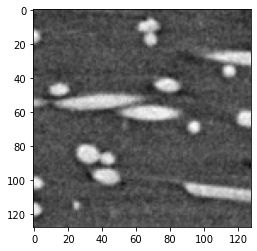

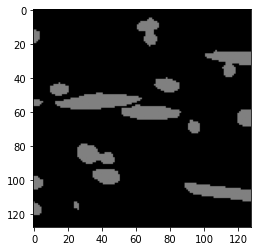

In [63]:
idx = 0

crop = list_of_examples[idx]
crop_data = crop["data"]
crop_labels = crop["labels"]

plt.figure()
plt.imshow(crop_data, cmap=cm.gray, vmin=0, vmax=255)

plt.figure()
plt.imshow(crop_labels, cmap=cm.gray, vmin=0, vmax=2);

## Porosity

In [64]:
list_of_examples = with_porosity

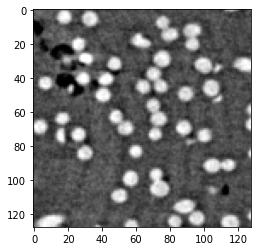

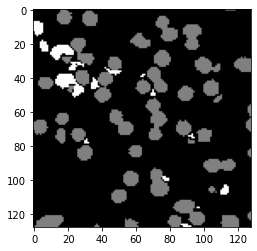

In [65]:
idx = 0

crop = list_of_examples[idx]
crop_data = crop["data"]
crop_labels = crop["labels"]

plt.figure()
plt.imshow(crop_data, cmap=cm.gray, vmin=0, vmax=255)

plt.figure()
plt.imshow(crop_labels, cmap=cm.gray, vmin=0, vmax=2);